In [19]:
# !pip install gdown

In [14]:
# import gdown
# url = "https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z&export=download&authuser=0"
# gdown.download(url, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z&export=download&authuser=0
From (redirected): https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z&export=download&authuser=0&confirm=t&uuid=f39130b8-e977-4527-b0d7-fe20859f45d0
To: /kaggle/working/MSFD.zip
100%|██████████| 2.25G/2.25G [00:23<00:00, 95.2MB/s]


'MSFD.zip'

In [23]:
# !unzip -q MSFD.zip

In [ ]:
# os._exit(0)

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torchvision.io import read_image
import cv2
import torchvision.transforms as transforms

In [10]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")

In [11]:
import wandb

wandb.login(key=secret_value_0)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [12]:
# import tqdm

# # Calculate the mean and std of the dataset

# dataset_path = "datasets/MSFD/1/face_crop"
# means = []
# stds = []

# # Create a progress bar to track the process
# for img_file in tqdm.tqdm(os.listdir(dataset_path), desc="Processing Images"):
#     img_path = os.path.join(dataset_path, img_file)
#     # Use OpenCV to load the image
#     img = cv2.imread(img_path)
#     if img is not None:
#         # Convert BGR to RGB
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         # Calculate mean and std per channel and normalize to [0, 1]
#         means.append(np.mean(img, axis=(0, 1)) / 255.0)
#         stds.append(np.std(img, axis=(0, 1)) / 255.0)

# # Calculate overall mean and std across all images
# dataset_mean = np.mean(means, axis=0)
# dataset_std = np.mean(stds, axis=0)

# print(f"Dataset mean: {dataset_mean}")
# print(f"Dataset std: {dataset_std}")

In [13]:
dataset_path = "./MSFD/1"

class MSFDDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, img_size=(128, 128)):
        self.dataset_path = dataset_path
        
        # Get all face image files
        face_dir = os.path.join(dataset_path, "face_crop")
        segmentation_dir = os.path.join(dataset_path, "face_crop_segmentation")
        
        # Only include images that have corresponding segmentation files
        self.image_files = []
        self.segmentation_files = []
        
        for img_name in os.listdir(face_dir):
            seg_name = img_name  # Matching segmentation should have same filename
            
            img_path = os.path.join(face_dir, img_name)
            seg_path = os.path.join(segmentation_dir, seg_name)
            
            # Only include if both files exist
            if os.path.exists(img_path) and os.path.exists(seg_path):
                self.image_files.append(img_name)
                self.segmentation_files.append(seg_name)
        
        self.img_size = img_size
        print(f"Found {len(self.image_files)} matched image-segmentation pairs")
        
        # Define transforms
        self.img_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.Normalize(mean=[0.52988076, 0.45696659, 0.43334861], std=[0.25698626, 0.23935081, 0.23180752])
        ])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image using OpenCV
        image_path = os.path.join(self.dataset_path, "face_crop", self.image_files[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        
        # Load segmentation using OpenCV
        segmentation_path = os.path.join(self.dataset_path, "face_crop_segmentation", self.segmentation_files[idx])
        segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)
        
        # Resize images to consistent size
        image = cv2.resize(image, self.img_size)
        segmentation = cv2.resize(segmentation, self.img_size, interpolation=cv2.INTER_NEAREST)
        
        # Convert to tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        segmentation = torch.tensor(segmentation, dtype=torch.long)
        
        # Apply normalization to image
        image = self.img_transform(image)
        
        return image, segmentation
    
dataset = MSFDDataset(dataset_path)

Found 9382 matched image-segmentation pairs


In [14]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

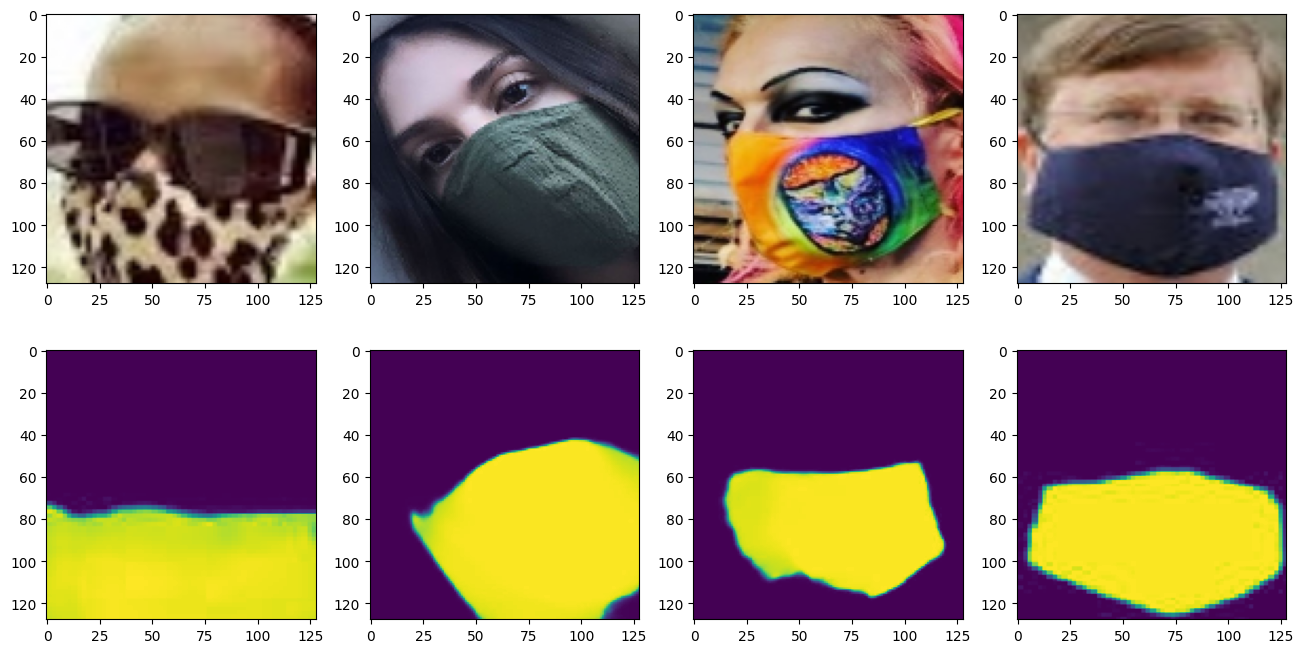

In [15]:
# Plot images and segmentations
import matplotlib.pyplot as plt

def plot_images(images, segmentations):
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    for i in range(4):
        axs[0, i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axs[1, i].imshow(segmentations[i].cpu().numpy())
    plt.show()

images, segmentations = next(iter(train_loader))

# Denormalize images
images = images * torch.tensor([0.25698626, 0.23935081, 0.23180752]).view(1, 3, 1, 1) + torch.tensor([0.52988076, 0.45696659, 0.43334861]).view(1, 3, 1, 1)
plot_images(images, segmentations)

In [16]:
# Define the U-Net model architecture for segmentation with hyperparameter flexibility
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=256, depth=4, filters_base=64, 
                 activation='relu', use_batchnorm=True, dropout_rate=0.0):
        super(UNet, self).__init__()
        
        self.depth = depth
        self.activation_name = activation
        self.use_batchnorm = use_batchnorm
        
        # Define activation function
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        else:
            self.activation = nn.ReLU(inplace=True)
            
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        
        # Create encoders, decoders, and upconv operations dynamically based on depth
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.upconvs = nn.ModuleList()
        
        # Create encoder blocks
        in_channels = n_channels
        for i in range(depth):
            out_channels = filters_base * (2**i)
            self.encoders.append(self._conv_block(in_channels, out_channels))
            in_channels = out_channels
            
        # Bottleneck
        bottleneck_channels = filters_base * (2**depth)
        self.bottleneck = self._conv_block(in_channels, bottleneck_channels)
        
        # Create decoder blocks
        in_channels = bottleneck_channels
        for i in range(depth):
            out_channels = filters_base * (2**(depth-i-1))
            self.upconvs.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2))
            self.decoders.append(self._conv_block(in_channels, out_channels))  # in_channels accounts for concatenation
            in_channels = out_channels
            
        # Final convolution
        self.final_conv = nn.Conv2d(filters_base, n_classes, kernel_size=1)
    
    def _conv_block(self, in_channels, out_channels):
        layers = []
        
        # First convolution
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        if self.use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        if self.dropout is not None:
            layers.append(self.dropout)
            
        # Second convolution
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        if self.use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        if self.dropout is not None:
            layers.append(self.dropout)
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Store encoder outputs for skip connections
        encoder_outputs = []
        
        # Encoding path
        for encoder in self.encoders:
            x = encoder(x)
            encoder_outputs.append(x)
            x = self.pool(x)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoding path with skip connections
        for i in range(self.depth):
            x = self.upconvs[i](x)
            skip_connection = encoder_outputs[self.depth - i - 1]
            
            # Handle the case where dimensions don't match exactly
            if x.shape != skip_connection.shape[2:]:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)
                
            x = torch.cat([x, skip_connection], dim=1)
            x = self.decoders[i](x)
        
        # Final convolution
        x = self.final_conv(x)
        
        return x

# # Initialize the model
# model = UNet(n_channels=3, n_classes=256)  # 256 classes as seen in segmentations
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = model.to(device)

# # Define the loss function (criterion)
# criterion = nn.CrossEntropyLoss()  # Appropriate for multi-class segmentation

In [17]:
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [18]:
from tqdm.notebook import tqdm

# Define the hyperparameter sweep configuration
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'min': 1e-3,
            'max': 1e-2,
            'distribution': 'uniform'
        },
        'batch_size': {
            'values': [64]
        },
        'depth': {
            'values': [2, 4, 6]
        },
        'filters_base': {
            'values': [16, 32, 64]
        },
        'activation': {
            'values': ['relu', 'leaky_relu']
        },
        'dropout_rate': {
            'min': 0.0,
            'max': 0.2
        },
        'use_batchnorm': {
            'values': [True, False]
        }
    }
}

In [19]:
# Define the training function that will be used in the sweep
def train_with_wandb():
    # Initialize a new wandb run
    with wandb.init() as run:
        # Get hyperparameters for this run
        config = wandb.config
        
        # Dataset normalization constants for proper denormalization
        mean = torch.tensor([0.53623614, 0.45724225, 0.4352597])
        std = torch.tensor([0.29512053, 0.27059418, 0.26198056])
        
        # Create data loaders with the batch size from config
        train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=config.batch_size, 
            shuffle=True, 
            num_workers=4, 
            pin_memory=True
        )
        
        # Create validation loader WITHOUT shuffling to ensure consistent order
        val_loader = torch.utils.data.DataLoader(
            val_dataset, 
            batch_size=config.batch_size, 
            shuffle=False,
            num_workers=4, 
            pin_memory=True
        )
        
        # Define fixed sample indices for visualization
        # These will be the same across all runs
        viz_sample_indices = [0, 10, 20, 30, 40]  # Choose specific indices from validation set
        
        # Create a separate loader just for visualization samples
        viz_dataset = torch.utils.data.Subset(val_dataset, viz_sample_indices)
        viz_loader = torch.utils.data.DataLoader(
            viz_dataset,
            batch_size=len(viz_sample_indices),
            shuffle=False,
            num_workers=1
        )
        
        # Create model with the hyperparameters from config
        model = UNet(
            n_channels=3,
            n_classes=256,
            depth=config.depth,
            filters_base=config.filters_base,
            activation=config.activation,
            use_batchnorm=config.use_batchnorm,
            dropout_rate=config.dropout_rate
        )
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        
        # Define optimizer with learning rate from config
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        
        # Define loss function
        criterion = nn.CrossEntropyLoss()
        
        # Initialize best validation accuracy for this run
        best_val_accuracy = 0
        
        # Helper function to denormalize images
        def denormalize(tensor):
            """
            Denormalizes a tensor using the dataset mean and std
            """
            tensor = tensor.clone().detach()
            for t, m, s in zip(tensor, mean, std):
                t.mul_(s).add_(m)
            return torch.clamp(tensor, 0, 1)
        
        # Helper function to create visualization grid
        def create_grid(images, targets, predictions):
            """
            Creates a grid with original images, targets and predictions
            Returns a single image as numpy array (H, W, 3)
            """
            # Denormalize images
            images_denorm = [denormalize(img) for img in images]
            
            # Convert targets and predictions to colored visualizations
            # Here we use a simple colormap, but you might want to use your specific class colors
            targets_viz = []
            preds_viz = []
            
            # Simple colormap for visualization - adjust based on your classes
            for i in range(len(images)):
                # Create colored version of target (using simple grayscale for now)
                target = targets[i].float() / 255.0 if targets[i].max() > 1 else targets[i].float()
                target_rgb = torch.cat([target.unsqueeze(0)] * 3, dim=0)  # Simple grayscale to RGB
                targets_viz.append(target_rgb)
                
                # Create colored version of prediction
                pred = predictions[i].float() / 255.0 if predictions[i].max() > 1 else predictions[i].float()
                pred_rgb = torch.cat([pred.unsqueeze(0)] * 3, dim=0)  # Simple grayscale to RGB
                preds_viz.append(pred_rgb)
            
            # Create rows of images, targets, predictions
            rows = []
            num_samples = len(images)
            
            # Row 1: Original Images
            row1 = torch.cat(images_denorm, dim=2)  # Concatenate along width
            rows.append(row1)
            
            # Row 2: Target Segmentations
            row2 = torch.cat(targets_viz, dim=2)
            rows.append(row2)
            
            # Row 3: Predicted Segmentations
            row3 = torch.cat(preds_viz, dim=2)
            rows.append(row3)
            
            # Stack rows to create grid
            grid = torch.cat(rows, dim=1)  # Concatenate along height
            
            # Convert to numpy and transpose to HWC
            grid_np = grid.permute(1, 2, 0).cpu().numpy()
            return grid_np
        
        # Training loop
        num_epochs = 10
        for epoch in range(num_epochs):
            torch.cuda.empty_cache()
            # Training phase
            model.train()
            train_losses = []
            
            for batch_idx, (data, targets) in enumerate(train_loader):
                data = data.to(device)
                targets = targets.to(device)
                
                # Forward pass
                scores = model(data)
                loss = criterion(scores, targets)
                train_losses.append(loss.item())
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Calculate average training loss
            avg_train_loss = sum(train_losses) / len(train_losses)
            
            # Validation phase
            model.eval()
            val_losses = []
            num_correct = 0
            num_pixels = 0
            
            with torch.no_grad():
                for data, targets in val_loader:
                    data = data.to(device)
                    targets = targets.to(device)
                    
                    # Forward pass
                    scores = model(data)
                    loss = criterion(scores, targets)
                    val_losses.append(loss.item())
                    
                    # Calculate accuracy
                    _, predictions = scores.max(1)
                    num_correct += (predictions == targets).sum().item()
                    num_pixels += targets.numel()
                
                # Generate visualizations for the fixed sample set
                for viz_data, viz_targets in viz_loader:
                    viz_data = viz_data.to(device)
                    viz_targets = viz_targets.to(device)
                    
                    viz_scores = model(viz_data)
                    _, viz_predictions = viz_scores.max(1)
                    
                    # Extract data for visualization
                    images = [img.cpu() for img in viz_data]
                    targets = [tgt.cpu() for tgt in viz_targets]
                    predictions = [pred.cpu() for pred in viz_predictions]
                    
                    # Create visualization grid
                    grid = create_grid(images, targets, predictions)
                    
                    # Log the grid image
                    wandb.log({
                        "visualization_grid": wandb.Image(
                            grid, 
                            caption=f"Top: Images, Middle: Ground Truth, Bottom: Predictions (Epoch {epoch})"
                        )
                    }, step=epoch)
                                
            # Calculate metrics
            val_accuracy = (num_correct / num_pixels)
            avg_val_loss = sum(val_losses) / len(val_losses)
            
            # Log metrics to wandb
            wandb.log({
                'epoch': epoch,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'val_accuracy': val_accuracy,
            })
            
            # Save best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(model.state_dict(), f"model_sweep_{wandb.run.id}.pth")
                # Log best accuracy to wandb
                wandb.run.summary["best_val_accuracy"] = best_val_accuracy
                
                # Log best model visualization separately
                for viz_data, viz_targets in viz_loader:
                    viz_data = viz_data.to(device)
                    viz_targets = viz_targets.to(device)
                    
                    viz_scores = model(viz_data)
                    _, viz_predictions = viz_scores.max(1)
                    
                    # Extract data for visualization
                    images = [img.cpu() for img in viz_data]
                    targets = [tgt.cpu() for tgt in viz_targets]
                    predictions = [pred.cpu() for pred in viz_predictions]
                    
                    # Create visualization grid
                    grid = create_grid(images, targets, predictions)
                    
                    # Log the grid for best model
                    wandb.run.summary["best_model_visualization"] = wandb.Image(
                        grid, 
                        caption=f"Best Model - Top: Images, Middle: Ground Truth, Bottom: Predictions (Epoch {epoch})"
                    )
        
        # Calculate IoU on validation set for final model
        model.eval()
        iou_sum = 0
        num_samples = 0
        
        with torch.no_grad():
            for data, targets in val_loader:
                data = data.to(device)
                targets = targets.to(device)
                
                scores = model(data)
                _, predictions = scores.max(1)
                
                # Calculate IoU - using a simplified approach for the sweep
                intersection = ((predictions > 0) & (targets > 0)).float().sum((1, 2))
                union = ((predictions > 0) | (targets > 0)).float().sum((1, 2)) + 1e-8
                iou = (intersection / union).mean()
                
                iou_sum += iou.item() * data.size(0)
                num_samples += data.size(0)
        
        # Log final IoU
        mean_iou = iou_sum / num_samples
        wandb.run.summary["mean_iou"] = mean_iou
        
        # Final grid for the final model (might be different from best model)
        with torch.no_grad():
            for viz_data, viz_targets in viz_loader:
                viz_data = viz_data.to(device)
                viz_targets = viz_targets.to(device)
                
                # Get predictions with the final model
                viz_scores = model(viz_data)
                _, viz_predictions = viz_scores.max(1)
                
                # Extract data for visualization
                images = [img.cpu() for img in viz_data]
                targets = [tgt.cpu() for tgt in viz_targets]
                predictions = [pred.cpu() for pred in viz_predictions]
                
                # Create visualization grid
                grid = create_grid(images, targets, predictions)
                
                # Log the grid for final model
                wandb.run.summary["final_model_visualization"] = wandb.Image(
                    grid, 
                    caption=f"Final Model - Top: Images, Middle: Ground Truth, Bottom: Predictions"
                )

In [20]:
# Create the sweep
sweep_id = wandb.sweep(sweep_config, project="masked-face-segmentation", entity='ritishtest1')

# Run the sweep
wandb.agent(sweep_id, function=train_with_wandb, count=10)  # Run 10 trials

Create sweep with ID: 6oc0z6vq
Sweep URL: https://wandb.ai/ritishtest1/masked-face-segmentation/sweeps/6oc0z6vq


wandb: Agent Starting Run: a57mqp33 with config:
wandb: 	activation: leaky_relu
wandb: 	batch_size: 64
wandb: 	depth: 6
wandb: 	dropout_rate: 0.17244419260803356
wandb: 	filters_base: 16
wandb: 	learning_rate: 0.002350957436048887
wandb: 	use_batchnorm: True


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▁▅▇███████
val_loss,█▃▂▂▁▂▁▁▁▁
best_val_accuracy,0.84602
epoch,9
mean_iou,0.82114
train_loss,0.75819
val_accuracy,0.84602
val_loss,0.74379


wandb: Agent Starting Run: 2ujg629j with config:
wandb: 	activation: leaky_relu
wandb: 	batch_size: 64
wandb: 	depth: 2
wandb: 	dropout_rate: 0.16452317434995992
wandb: 	filters_base: 64
wandb: 	learning_rate: 0.006232175576710181
wandb: 	use_batchnorm: True


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▄▇▅▇███
val_loss,█▅▄▅▃▄▂▂▁▁
best_val_accuracy,0.82366
epoch,9
mean_iou,0.69952
train_loss,0.86491
val_accuracy,0.82252
val_loss,0.87831


wandb: Agent Starting Run: xqi6emfv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	depth: 4
wandb: 	dropout_rate: 0.13271792879857297
wandb: 	filters_base: 16
wandb: 	learning_rate: 0.008588336836496695
wandb: 	use_batchnorm: False


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁
best_val_accuracy,0.62532
epoch,9
mean_iou,0
train_loss,1.58533
val_accuracy,0.62532
val_loss,1.53479


wandb: Agent Starting Run: 4m7tm7sg with config:
wandb: 	activation: leaky_relu
wandb: 	batch_size: 64
wandb: 	depth: 4
wandb: 	dropout_rate: 0.1746327935285471
wandb: 	filters_base: 16
wandb: 	learning_rate: 0.009386139686897516
wandb: 	use_batchnorm: True


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▄▇████▇█
val_loss,█▆▆▃▂▂▁▁▂▁
best_val_accuracy,0.8457
epoch,9
mean_iou,0.81659
train_loss,0.77132
val_accuracy,0.8457
val_loss,0.76407


wandb: Agent Starting Run: dw9wlypz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	depth: 2
wandb: 	dropout_rate: 0.13797515329201454
wandb: 	filters_base: 64
wandb: 	learning_rate: 0.0010857775898796185
wandb: 	use_batchnorm: False


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▆▄▄▃▂▂▁▁▁
best_val_accuracy,0.82735
epoch,9
mean_iou,0.75497
train_loss,0.87422
val_accuracy,0.82735
val_loss,0.83552


wandb: Agent Starting Run: e4topz6f with config:
wandb: 	activation: leaky_relu
wandb: 	batch_size: 64
wandb: 	depth: 6
wandb: 	dropout_rate: 0.08430671095309264
wandb: 	filters_base: 16
wandb: 	learning_rate: 0.003101378516309937
wandb: 	use_batchnorm: False


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,▁█▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▂▁▂▁▁▁
val_loss,▁▇█▆▅▅▄▄▄▄
best_val_accuracy,0.2512
epoch,9
mean_iou,0.3744
train_loss,182249069189085.28
val_accuracy,0.01742
val_loss,2.075720771754612e+16


wandb: Agent Starting Run: p0kvilkc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	depth: 4
wandb: 	dropout_rate: 0.12151534192578038
wandb: 	filters_base: 16
wandb: 	learning_rate: 0.009917902697915242
wandb: 	use_batchnorm: False


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁████████
val_loss,█▄▁▁▁▁▁▁▁▁
best_val_accuracy,0.62532
epoch,9
mean_iou,0
train_loss,1.56208
val_accuracy,0.62532
val_loss,1.52646


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p3qwzeik with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	depth: 4
wandb: 	dropout_rate: 0.1645934261087587
wandb: 	filters_base: 64
wandb: 	learning_rate: 0.0011863215635483624
wandb: 	use_batchnorm: False


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇█████
val_loss,█▅▄▃▃▃▂▂▁▁
best_val_accuracy,0.83724
epoch,9
mean_iou,0.81639
train_loss,0.84668
val_accuracy,0.83618
val_loss,0.86777


wandb: Agent Starting Run: 0qdsfg5a with config:
wandb: 	activation: leaky_relu
wandb: 	batch_size: 64
wandb: 	depth: 4
wandb: 	dropout_rate: 0.14976435187655768
wandb: 	filters_base: 64
wandb: 	learning_rate: 0.0042923627754217954
wandb: 	use_batchnorm: True


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▆▅▄▃▂▂▁▂▁
best_val_accuracy,0.84751
epoch,9
mean_iou,0.82314
train_loss,0.72707
val_accuracy,0.84751
val_loss,0.72558


wandb: Agent Starting Run: yjwybr1t with config:
wandb: 	activation: leaky_relu
wandb: 	batch_size: 64
wandb: 	depth: 4
wandb: 	dropout_rate: 0.13800755074678503
wandb: 	filters_base: 64
wandb: 	learning_rate: 0.0038396853217029583
wandb: 	use_batchnorm: True


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▄▆▇▇████
val_loss,█▆▆▄▃▃▂▂▂▁
best_val_accuracy,0.84832
epoch,9
mean_iou,0.83071
train_loss,0.72152
val_accuracy,0.84832
val_loss,0.70639


In [22]:
wandb.finish()

In [15]:
# import tqdm
# from tqdm.notebook import tqdm
# import time

# # Training loop

# # Initialize to track best validation accuracy
# best_val_accuracy = 0
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# num_epochs = 10
# for epoch in range(num_epochs):
#     # Training
#     model.train()
#     train_losses = []
#     loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    
#     for batch_idx, (data, targets) in enumerate(loop):
#         data = data.to(device=device)
#         targets = targets.to(device=device)
        
#         # Forward pass
#         scores = model(data)
#         loss = criterion(scores, targets)
#         train_losses.append(loss.item())
        
#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         # Update progress bar
#         loop.set_postfix(loss=loss.item())
    
#     # Calculate average training loss for this epoch
#     avg_train_loss = sum(train_losses) / len(train_losses)
    
#     # Validation
#     model.eval()
#     num_correct = 0
#     num_pixels = 0
#     val_losses = []
    
#     with torch.no_grad():
#         val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
#         for data, targets in val_loop:
#             data = data.to(device=device)
#             targets = targets.to(device=device)
            
#             # Forward pass
#             scores = model(data)
#             loss = criterion(scores, targets)
#             val_losses.append(loss.item())
            
#             # Calculate accuracy
#             _, predictions = scores.max(1)
#             num_correct += (predictions == targets).sum()
#             num_pixels += torch.numel(predictions)
            
#             # Update progress bar
#             val_loop.set_postfix(loss=loss.item())
    
#     # Calculate average validation loss and accuracy
#     val_accuracy = (num_correct / num_pixels).item()
#     avg_val_loss = sum(val_losses) / len(val_losses)
    
#     # Print epoch summary
#     print(f"Epoch {epoch+1}/{num_epochs}")
#     print(f"Train Loss: {avg_train_loss:.4f}")
#     print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
#     # Save best model
#     if val_accuracy > best_val_accuracy:
#         best_val_accuracy = val_accuracy
#         torch.save(model.state_dict(), "best_segmentation_model.pth")
#         print(f"Saved best model with accuracy: {best_val_accuracy:.4f}")
    
#     print("-" * 50)

Epoch 1/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.9198
Val Loss: 0.8722, Val Accuracy: 0.8351
Saved best model with accuracy: 0.8351
--------------------------------------------------


Epoch 2/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.8873
Val Loss: 0.8567, Val Accuracy: 0.8363
Saved best model with accuracy: 0.8363
--------------------------------------------------


Epoch 3/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.8624
Val Loss: 0.8301, Val Accuracy: 0.8401
Saved best model with accuracy: 0.8401
--------------------------------------------------


Epoch 4/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.8381
Val Loss: 0.8026, Val Accuracy: 0.8427
Saved best model with accuracy: 0.8427
--------------------------------------------------


Epoch 5/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.8142
Val Loss: 0.7983, Val Accuracy: 0.8432
Saved best model with accuracy: 0.8432
--------------------------------------------------


Epoch 6/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.7945
Val Loss: 0.7660, Val Accuracy: 0.8451
Saved best model with accuracy: 0.8451
--------------------------------------------------


Epoch 7/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/10
Train Loss: 0.7758
Val Loss: 0.7629, Val Accuracy: 0.8447
--------------------------------------------------


Epoch 8/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8/10
Train Loss: 0.7554
Val Loss: 0.7460, Val Accuracy: 0.8466
Saved best model with accuracy: 0.8466
--------------------------------------------------


Epoch 9/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/10
Train Loss: 0.7436
Val Loss: 0.7297, Val Accuracy: 0.8472
Saved best model with accuracy: 0.8472
--------------------------------------------------


Epoch 10/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/10
Train Loss: 0.7281
Val Loss: 0.7234, Val Accuracy: 0.8474
Saved best model with accuracy: 0.8474
--------------------------------------------------


In [24]:
# # Plot original image, segmentation, and predicted segmentation
# import matplotlib.pyplot as plt

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# def plot_image_and_segmentation(image, segmentation, predicted_segmentation):
#     fig, ax = plt.subplots(1, 3, figsize=(12, 6))
#     ax[0].imshow(image.permute(1, 2, 0))
#     ax[1].imshow(segmentation, cmap='viridis')
#     ax[2].imshow(predicted_segmentation, cmap='viridis')
#     plt.show()

# # Get a random image and segmentation from the validation set
# idx = np.random.randint(len(val_dataset))
# image, segmentation = val_dataset[idx]
# image = image.unsqueeze(0).to(device=device)
# segmentation = segmentation.unsqueeze(0).to(device=device)

# # Get the predicted segmentation
# predicted_segmentation = model(image)
# _, predicted_segmentation = predicted_segmentation.max(1)
# predicted_segmentation = predicted_segmentation.cpu().numpy().squeeze()

# # Denormalize the image
# image = image.cpu() * torch.tensor([0.25698626, 0.23935081, 0.23180752]).view(1, 3, 1, 1) + torch.tensor([0.52988076, 0.45696659, 0.43334861]).view(1, 3, 1, 1)


# # Plot the image and segmentations
# plot_image_and_segmentation(image.cpu().squeeze(), segmentation.cpu().squeeze(), predicted_segmentation)

NameError: name 'model' is not defined

In [29]:
# Calculate average IOU over validation set
model.eval()
num_correct = 0
num_pixels = 0

with torch.no_grad():
    for data, targets in val_loader:
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Forward pass
        scores = model(data)
        _, predictions = scores.max(1)
        
        # Calculate IOU
        intersection = (predictions & targets).float().sum((1, 2))  # Intersection
        union = (predictions | targets).float().sum((1, 2))  # Union
        iou = (intersection + 1e-6) / (union + 1e-6)  # Avoid division by zero
        
        # Accumulate IOU
        num_correct += iou.sum()
        num_pixels += torch.numel(iou)

# Calculate average IOU
avg_iou = num_correct / num_pixels
print(f"Average IOU: {avg_iou.item():.4f}")

Average IOU: 0.8831
